In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from __future__ import division
%matplotlib inline
import gc
import collections

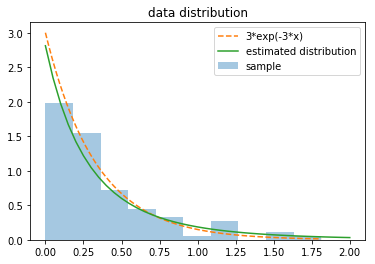

In [89]:
#generate data
sample = np.random.exponential(scale=1/3, size=100)
sns.distplot(list(sample), kde=False, norm_hist=True, bins=np.linspace(0, max(sample), 11), label='sample')
x = np.linspace(0, sample.max(), 1000)
plt.plot(x, 3*np.exp(-3*x),'--', label = '3*exp(-3*x)')

plt.title('data distribution')
plt.legend()
plt.show()

In [90]:
def g_j(j, x):
    return j*np.exp(-j*x)

In [5]:
def likelihood(M, w, data): #likelihood density
    return np.array([(w*g_j(np.arange(1, M+1), x)).sum() for x in data]).prod()

In [6]:
def draw_d(w, M, x): #sampling of latent variable
    '''
    :type w: np.array
    :type M: int
    :type x: float
    :rtype: int
    '''
    assert len(w)==M
    pr = w*g_j(np.arange(1, M+1), x)
    pr /= pr.sum()
    res = np.random.choice(M, 1, p=pr)
    return res

In [7]:
def draw_w(M, d, X): #sampling weight
    assert len(d)==len(X)
    w_alpha = np.arange(M)
    cnt = collections.Counter(w_alpha)
    cnt += collections.Counter(d)
    return np.random.dirichlet(list(cnt.values()))

In [8]:
def M_up(M, w, data): #acceptance probablity of moving up
    p_accept = 1/likelihood(M, w, data)
    #split w
    idx = np.random.randint(M)
    w_split = np.random.beta(2, 2)
    w = np.append(w, w[idx]*(1-w_split))
    w[idx] *= w_split
    #acceptance rate
    p_accept *= likelihood(M+1, w, data)/6/(w_split*(1-w_split))
    return p_accept, w

In [9]:
def M_down(M, w, data): #acceptance probablity of moving down
    p_accept = 1/likelihood(M, w, data)
    #combine two w
    idx = np.random.randint(M-1)
    w[idx] += w[-1]
    w = w[:-1]
    #acceptance rate
    w_split = np.random.beta(2, 2)
    p_accept *= likelihood(M-1, w, data)*6*(w_split*(1-w_split))
    return p_accept, w

In [10]:
def draw_M(M, w, data): #Metropolis step for M
    u = np.random.uniform()
    p, w_up = M_up(M, w, data)
    if M == 1: # M can only go up in this case
        if u < p:
            return M+1, w_upplt.legend()
        else:
            return M, w
    
    if np.random.randint(2): # propose to go up
        if u<p: # accepted to go up
            return M+1, w_up
        else: # stay
            return M, w
    else:
        p, w_down = M_down(M, w, data)
        if u < p: # accepted to go down
            return M-1, w_down
        else: # stay
            return M, w


In [11]:
M = 1 #start with M=1, most probable M value
N = 5000 #run N iterations
w = np.random.dirichlet(np.ones(M)) #sample w from prior
sample2 = []
Ms = []
indices = []
w_list = []
for i in range(N):
    if i%1000 == 0:
        print(i)
    d = np.array([draw_d(w, M, x)[0] for x in sample]) #sample d first
    w = draw_w(M, d, sample) #sample w
    w_list.append(w)
    idx = np.random.choice(M, 1, p=w)[0]
    indices.append(idx)
    sample2.append(np.random.exponential(scale=1/(idx+1)))
    Ms.append(M)
    M, w = draw_M(M, w, sample) #sample M

0
1000
2000
3000
4000


Text(0,0.5,u'M')

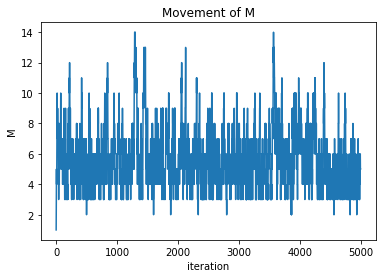

In [57]:
plt.plot(Ms)
plt.title("Movement of M")
plt.xlabel('iteration')
plt.ylabel('M')

In [91]:
print('Number of moving up', (np.diff(np.array(Ms))==1).sum())
print('Number of moving down', (np.diff(np.array(Ms))==-1).sum())
print('Number of staying', (np.diff(np.array(Ms))==0).sum())

('Number of moving up', 1700)
('Number of moving down', 1696)
('Number of staying', 1603)


Text(0.5,1,u'histogram of M')

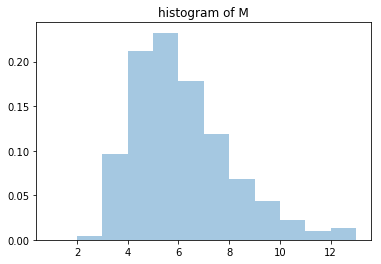

In [59]:
sns.distplot(Ms, kde=False, norm_hist=True, bins=range(1, max(Ms)))
plt.title('histogram of M')

In [45]:
np.mean(Ms)

5.6581999999999999

Text(0.5,1,u'Samples from Gibbs sampler')

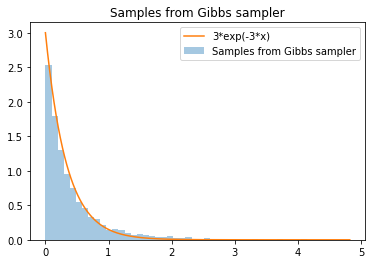

In [60]:
sns.distplot(sample2, kde=False, norm_hist=True, label='Samples from Gibbs sampler')
x = np.linspace(0, max(sample2), 1000)
plt.plot(x, 3*np.exp(-3*x), label='3*exp(-3*x)')
plt.legend()
plt.title('Samples from Gibbs sampler')

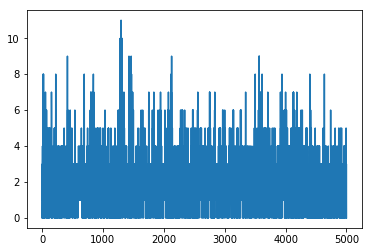

In [15]:
plt.plot(indices)

In [65]:
len(indices)

5000

Text(0.5,1,u'latent variables')

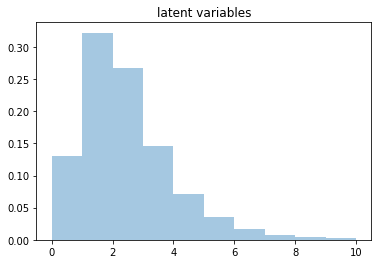

In [62]:
sns.distplot(indices, kde=False, norm_hist=True, bins=np.arange(max(indices)))
plt.title('latent variables')

In [17]:
sample_mean = [np.mean(sample2[:i]) for i in range(1, N+1)]

Text(0,0.5,u'sample mean')

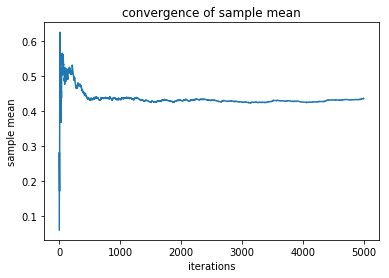

In [67]:
plt.plot(range(1, N+1), sample_mean)
plt.title('convergence of sample mean')
plt.xlabel('iterations')
plt.ylabel('sample mean')

Text(0.5,1,u'Samples from Gibbs sampler')

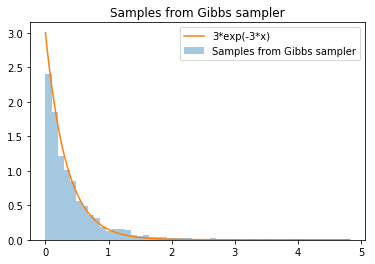

In [70]:
sns.distplot(sample2[:2000], kde=False, norm_hist=True, label='Samples from Gibbs sampler')
x = np.linspace(0, max(sample2), 1000)
plt.plot(x, 3*np.exp(-3*x), label='3*exp(-3*x)')
plt.legend()
plt.title('Samples from Gibbs sampler')

In [20]:
sample.mean(), np.mean(sample2)

(0.40347928908006681, 0.4365381142395704)

In [21]:
gc.collect()

65

In [22]:
X = np.linspace(0, 5, 101)

In [23]:
def computeDistribution(x, w_list):
    n = len(w_list)
    return (w_list*g_j(np.arange(1, n+1), x)).sum()

In [41]:
y = X*0
for w in w_list[500:]:
    y += np.array([computeDistribution(x, w) for x in X])
y /= N

Text(0.5,1,u'estimated distribution')

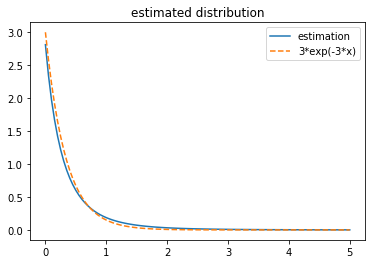

In [71]:
plt.plot(X, y, label = 'estimation')
plt.plot(X, 3*np.exp(-3*X), '--', label='3*exp(-3*x)')
plt.legend()
plt.title('estimated distribution')